![](../src/image/meli5.JPG)

# Generador Embeddings Text-Embedding-3-Small

#### En este punto usare  el text-embedding-3-small para la generacion de los embeddings.

### Pasos
1. [Preparacion de la data.](#1)
1. [Preprocesamiento de los datos.](#2)
1. [Generacion de Embedding](#3)
1. [Extraccion de Embedding](#4)


<a id="1"></a> <br>
# 1. Preparacion de la data

#### El dataset usado es el proporcionado en el ejercicio ya con las etiquetas obtenidas en la clusterizacion. El dataset posee 185250 registros los cuales 42711 poseen etiquetas. Esta data mantiene la informacion de sellers de un e-commerce. de los cuales tomaremos 200 registros de cada cluster, 10 de los que no tienen etiqueta para la prediccion.

#### Combinaran las variables, y con el modelo se codificara las variables combinadas y dara resultado un vector embedding

In [4]:
import pandas as pd
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
#openai
from openai import OpenAI
from utils.embeddings_utils import get_embedding

In [5]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  

In [6]:
path = 'D:\Clustering_MeLi\src\data\processed\data_num_wo_rp_v3.csv'
df = pd.read_csv(path)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42711 entries, 0 to 42710
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       42711 non-null  int64  
 1   seller_nickname  42711 non-null  object 
 2   stock            42711 non-null  int64  
 3   price            42711 non-null  float64
 4   Products         42711 non-null  int64  
 5   total_amount     42711 non-null  float64
 6   Kmeans           42711 non-null  int64  
 7   AgC              42711 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 2.6+ MB


In [8]:
df.columns

Index(['Unnamed: 0', 'seller_nickname', 'stock', 'price', 'Products',
       'total_amount', 'Kmeans', 'AgC'],
      dtype='object')

In [9]:
df['stock']=df['stock'].astype(str)
df['price']=df['price'].astype(str)
df['stock']=df['stock'].astype(str)
df['Products']=df['Products'].astype(str)
df['total_amount']=df['total_amount'].astype(str)
df['Kmeans']=df['Kmeans'].astype(str)
df['AgC']=df['AgC'].astype(str)

df.drop('Unnamed: 0',axis=1,inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42711 entries, 0 to 42710
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   seller_nickname  42711 non-null  object
 1   stock            42711 non-null  object
 2   price            42711 non-null  object
 3   Products         42711 non-null  object
 4   total_amount     42711 non-null  object
 5   Kmeans           42711 non-null  object
 6   AgC              42711 non-null  object
dtypes: object(7)
memory usage: 2.3+ MB


In [11]:
df['mix'] = "Stock: " + df['stock'].str.strip() + "; Price: " + df['price'].str.strip() + ";  Products: " + df.Products.str.strip() + "; total_amount: " + df.total_amount.str.strip() 
print(df.shape)


df.head(2)

(42711, 8)


,seller_nickname,stock,price,Products,total_amount,Kmeans,AgC,mix
0,000631669c,10,799.0,1,7990.0,0,3,Stock: 10; Price: 799.0; Products: 1; total_a...
1,0007153bca,55,798.0,2,43890.0,0,3,Stock: 55; Price: 798.0; Products: 2; total_a...


#### Como mencione anteriormente seleccionaremos 50 de cada cluster para tener una data de 250registros

In [12]:
df.columns

Index(['seller_nickname', 'stock', 'price', 'Products', 'total_amount',
       'Kmeans', 'AgC', 'mix'],
      dtype='object')

In [13]:
df['Kmeans'].value_counts()

Kmeans
0    37984
4     3722
3      679
1      321
2        5
Name: count, dtype: int64

In [14]:
col = ['seller_nickname', 'stock', 'price', 'Products', 'total_amount', 'Kmeans', 'AgC', 'mix']
cntxcluster = 200
clusters=5
dfy=pd.DataFrame()
for i in range(0,clusters): # Sacamos los 50 registros de cada cluster.
    print(f"Cluster {i}")
    reviews = df[df.Kmeans == str(i)].sample(cntxcluster, random_state=42, replace=True).values
    dfx = pd.DataFrame(data=reviews,columns=col)
    dfy = pd.concat([dfy,dfx], axis=0)



print(dfy.shape)
print(dfy.Kmeans.value_counts())
dfy = pd.concat([dfy,df[df['Kmeans'].isnull()][:10]], axis=0) # concatenamos con los
print(dfy.shape)
dfy = dfy.iloc[np.random.permutation(len(dfy))].reset_index(drop=True)
dfy.head(2)

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
(1000, 8)
Kmeans
0    200
1    200
2    200
3    200
4    200
Name: count, dtype: int64
(1000, 8)


,seller_nickname,stock,price,Products,total_amount,Kmeans,AgC,mix
0,79bc4f1d8e,6,4321.0,6,25926.0,0,3,Stock: 6; Price: 4321.0; Products: 6; total_a...
1,e68461b5aa,375,37914.14,45,14217802.5,3,4,Stock: 375; Price: 37914.14; Products: 45; to...


<a id="2"></a> <br>
# 2. Preprocesamiento de Datos

#### Ya con la data seleccionada ahora lo que realizaremos sera la tokenizacion  con tiktoken utilizando el encoding de 3-small definido al inicio.

In [15]:
encoding = tiktoken.get_encoding(embedding_encoding)

#Dado que utilizar la API de OpenAI no es gratis, debemos tartar de controlar los token
#que vamos a gastar con el fin de no gastar creditos innecesarios. por esa razon no tomamos la variable titulo
#ya que es demasiada grande esus strings.
# tambien es importante revisar que tanto es la maxima cantidad de token ya que se el
# 3-small tienen un limite de 8000 tokens por entrada o por registro.
dfy['tokens'] = dfy.mix.apply(lambda x: len(encoding.encode(x)))


28218


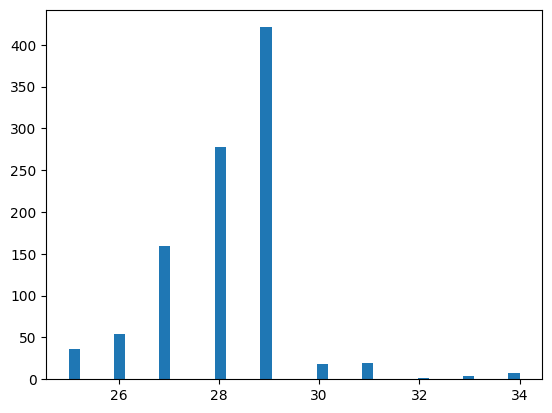

In [16]:
print(sum(dfy.tokens.values))
plt.hist(dfy.tokens, bins= 40);


<a id="3"></a> <br>
# 3. Generacion de Embedding

##### para esta primera prueba utilizaremos de input 85977 tokens de entrada y de respuesta seran 250.

In [17]:
# antes de correr cualquier modelo de la api de openai debemos asegurarnos que esta ya esta,
#completamente configurada en el ambiente.

#ahora
dfy["embedding"] = dfy.mix.apply(lambda x: get_embedding(x, model=embedding_model))



In [18]:
dfy.head(5)

,seller_nickname,stock,price,Products,total_amount,Kmeans,AgC,mix,tokens,embedding
0,79bc4f1d8e,6,4321.0,6,25926.0,0,3,Stock: 6; Price: 4321.0; Products: 6; total_a...,27,"[0.014002759009599686, -0.06299937516450882, 0..."
1,e68461b5aa,375,37914.14,45,14217802.5,3,4,Stock: 375; Price: 37914.14; Products: 45; to...,28,"[0.016240794211626053, -0.045103155076503754, ..."
2,463ab6ee52,19989,723.92,1,14470436.88,1,0,Stock: 19989; Price: 723.92; Products: 1; tot...,28,"[0.002073021838441491, -0.057836007326841354, ..."
3,602f9fa86b,16005,1820.0,5,29129100.0,1,0,Stock: 16005; Price: 1820.0; Products: 5; tot...,29,"[-0.007012698799371719, -0.05804700776934624, ..."
4,a3e6070134,2,5848.0,2,11696.0,0,3,Stock: 2; Price: 5848.0; Products: 2; total_a...,27,"[0.01843475177884102, -0.06605353206396103, 0...."


In [19]:
#ahora vemos nuestras lista los embedding desde 3-small de la muestra de nuestros datos.
print(dfy['embedding'].shape)
dfy['embedding']

(1000,)


0      [0.014002759009599686, -0.06299937516450882, 0...
1      [0.016240794211626053, -0.045103155076503754, ...
2      [0.002073021838441491, -0.057836007326841354, ...
3      [-0.007012698799371719, -0.05804700776934624, ...
4      [0.01843475177884102, -0.06605353206396103, 0....
                             ...                        
995    [0.020032653585076332, -0.05337682366371155, 0...
996    [0.020963650196790695, -0.05312364920973778, 0...
997    [0.01735766977071762, -0.040565375238657, 0.02...
998    [0.030963847413659096, -0.048469725996255875, ...
999    [0.014759722165763378, -0.0693286657333374, 0....
Name: embedding, Length: 1000, dtype: object

<a id="4"></a> <br>
# 4. Exportacion del Embedding

In [20]:
# #Exportamos el embedding
dfy.to_csv("D:\Clustering_MeLi\src\data\processed\data_embedding_numeric_wo_rp.csv")
